<a href="https://colab.research.google.com/github/Navoditamathur/ImageCrackSegmentationUnet/blob/main/wave_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip /content/drive/MyDrive/crack_segmentation_dataset.zip

Archive:  /content/drive/MyDrive/crack_segmentation_dataset.zip
replace __MACOSX/._crack_segmentation_dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
from glob import glob

path_images = r'crack_segmentation_dataset/images/'
path_masks = r'crack_segmentation_dataset/masks/'

images_paths = glob(path_images + '*.jpg')
masks_paths = glob(path_masks + '*.jpg')

images_paths = sorted([str(p) for p in images_paths])
masks_paths = sorted([str(p) for p in masks_paths])

df = pd.DataFrame({'images': images_paths, 'masks': masks_paths})

df.sample(2)

,images,masks
4100,crack_segmentation_dataset/images/GAPS384_trai...,crack_segmentation_dataset/masks/GAPS384_train...
7774,crack_segmentation_dataset/images/Rissbilder_f...,crack_segmentation_dataset/masks/Rissbilder_fo...


In [5]:
df = df.sample(n=1000, random_state=42)  # You can use any random_state value

In [6]:
seed = 42

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1, shuffle=True, random_state=seed)
print(f'Train size: {len(train_df)}, and test size: {len(test_df)}')

Train size: 900, and test size: 100


In [8]:
# Function to load and preprocess images
def load_and_preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (256, 256))  # Resize to 256x256
    img = tf.image.convert_image_dtype(img, tf.float32)  # Convert to float32
    return img

# Function to load and preprocess masks
def load_and_preprocess_mask(file_path):
    mask = tf.io.read_file(file_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (256, 256))  # Resize to 256x256
    mask = tf.image.convert_image_dtype(mask, tf.float32)  # Convert to float32
    mask = tf.where(mask >= 0.5, 1.0, 0.0)  # Threshold to convert to binary mask
    mask = mask / 255.0  # Normalize to [0, 1]
    return mask

In [9]:
test_img_ds = tf.data.Dataset.from_tensor_slices(test_df['images'])
test_mask_ds = tf.data.Dataset.from_tensor_slices(test_df['masks'])

In [10]:
test_img_ds = test_img_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_mask_ds = test_mask_ds.map(load_and_preprocess_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [11]:
test_dataset = tf.data.Dataset.zip((test_img_ds, test_mask_ds))

In [12]:
BATCH_SIZE = 8
BUFFER_SIZE = 1000

In [13]:
test_size = len(test_dataset)
test_batches = test_dataset.take(test_size).batch(BATCH_SIZE)

In [14]:
from Wavelet_UNet import Wavelet_UNet, dice_coef, dice_coef_loss
from keras.optimizers import Adam

wavelet_unet_model = Wavelet_UNet()
wavelet_unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['batch_normalization[0][0

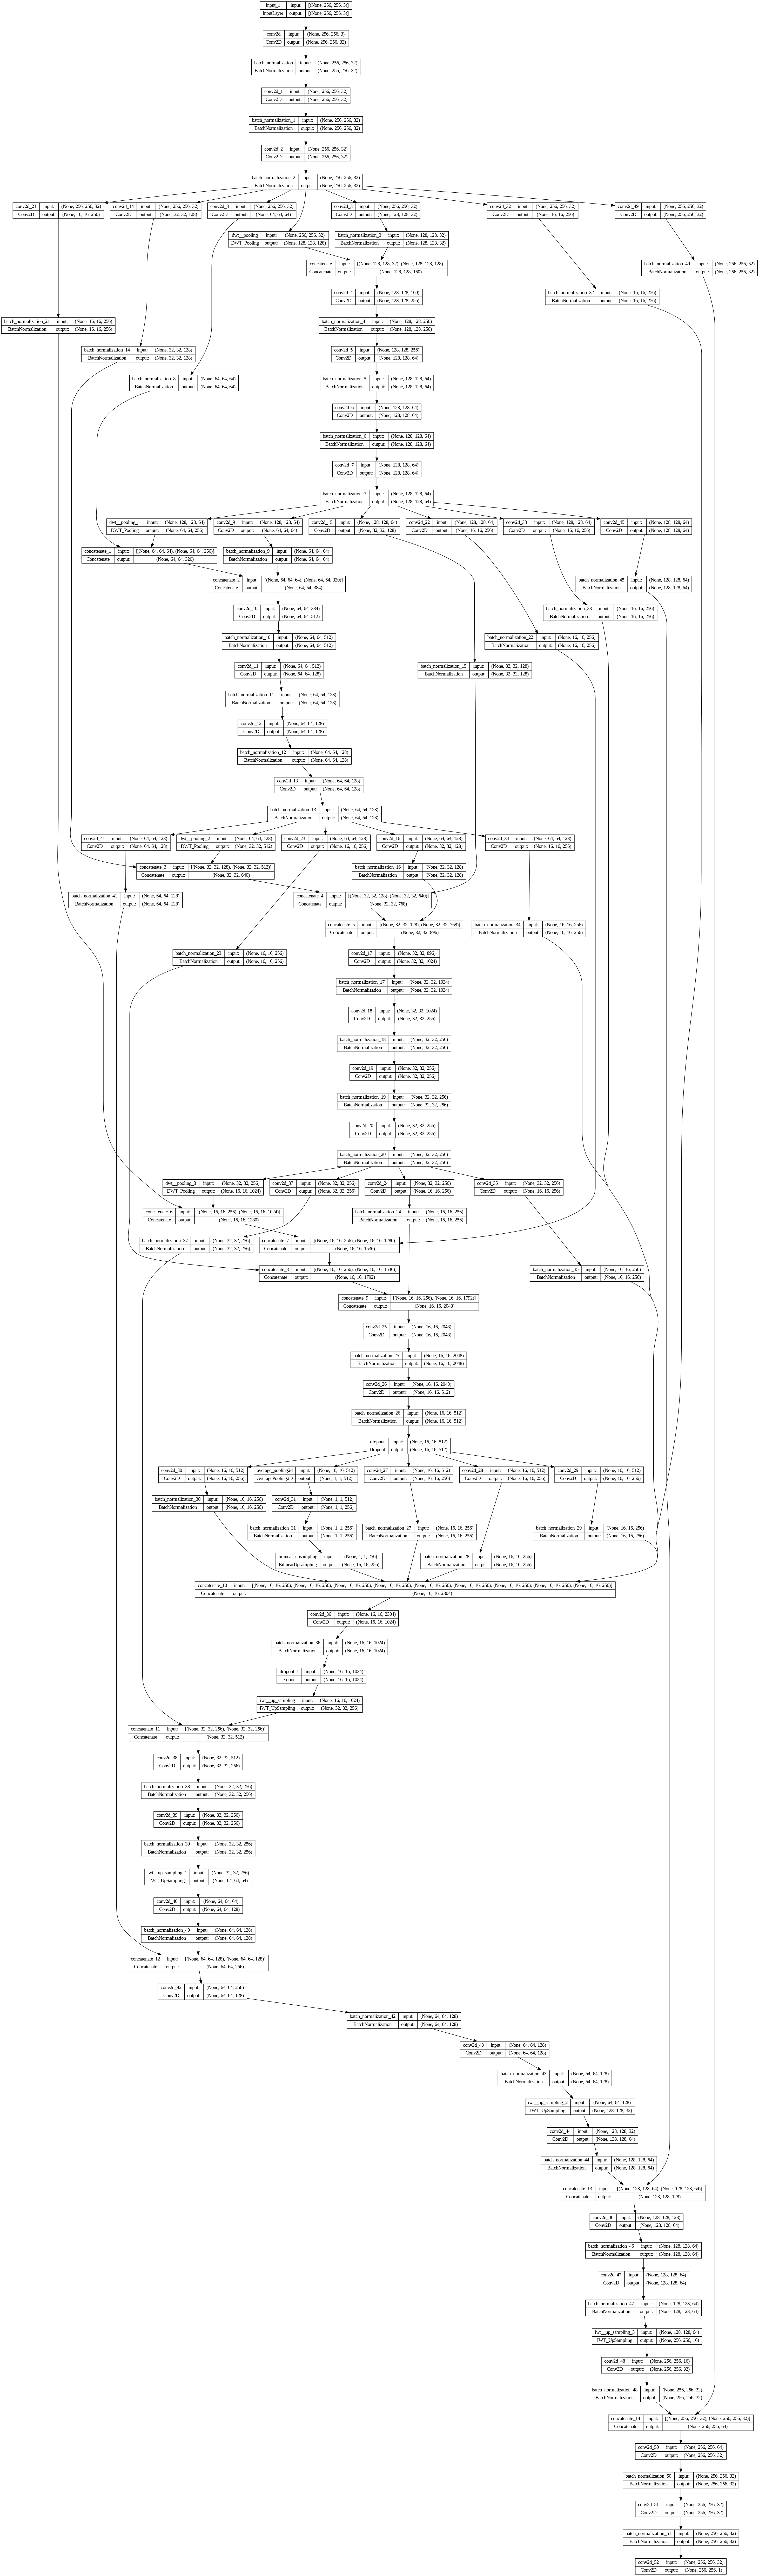

In [15]:
import tensorflow as tf
tf.keras.utils.plot_model(wavelet_unet_model, show_shapes=True)

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping

# Build the model
wavelet_unet_model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=[dice_coef,'accuracy',
                                                                          tf.keras.metrics.MeanIoU(num_classes=2)])

# Assuming len(test_dataset) is the total size of your test dataset
test_size = len(test_dataset)
test_batches = test_dataset.batch(BATCH_SIZE)
NUM_EPOCHS = 10

# 5-fold Cross-Validation with Early Stopping
kf = KFold(n_splits=3, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kf.split(train_df)):
    print(f"Fold {fold + 1}")
    train = train_df.iloc[train_index]
    valid = train_df.iloc[val_index]

    # Create datasets for images and masks
    train_img_ds = tf.data.Dataset.from_tensor_slices(train_df['images'])
    train_mask_ds = tf.data.Dataset.from_tensor_slices(train_df['masks'])

    valid_img_ds = tf.data.Dataset.from_tensor_slices(train_df['images'])
    valid_mask_ds = tf.data.Dataset.from_tensor_slices(train_df['masks'])

    # Load and preprocess the images and masks
    train_img_ds = train_img_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_mask_ds = train_mask_ds.map(load_and_preprocess_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    valid_img_ds = valid_img_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    valid_mask_ds = valid_mask_ds.map(load_and_preprocess_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    fold_train_dataset = tf.data.Dataset.zip((train_img_ds, train_mask_ds))
    fold_val_dataset = tf.data.Dataset.zip((valid_img_ds, valid_mask_ds))

    # Set up batches for this fold
    fold_train_batches = fold_train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    fold_train_batches = fold_train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    fold_val_batches = fold_val_dataset.batch(BATCH_SIZE)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    TRAIN_LENGTH = len(train)
    STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

    VAL_SUBSPLITS = 5
    VAL_LENGTH = len(valid)
    VALIDATION_STEPS = VAL_LENGTH // BATCH_SIZE // VAL_SUBSPLITS

    # Train the model for this fold
    fold_history = wavelet_unet_model.fit(
        fold_train_batches,
        epochs=NUM_EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_data=fold_val_batches,
        validation_steps=VALIDATION_STEPS,
        callbacks=[early_stopping]
    )

    # Optionally, you can save the model for each fold
    wavelet_unet_model.save(f'model_fold_{fold + 1}.h5')


Fold 1
Epoch 1/10
75/75 [==============================] - 94s 618ms/step - loss: 0.7950 - dice_coef: 8.4871e-04 - accuracy: 0.8220 - mean_io_u: 0.5000 - val_loss: 0.2406 - val_dice_coef: 8.2986e-04 - val_accuracy: 0.9495 - val_mean_io_u: 0.4993
Epoch 2/10
75/75 [==============================] - 51s 682ms/step - loss: 0.4214 - dice_coef: 0.0015 - accuracy: 0.9539 - mean_io_u: 1.0000 - val_loss: 0.2787 - val_dice_coef: 0.0022 - val_accuracy: 0.9539 - val_mean_io_u: 1.0000
Epoch 3/10
75/75 [==============================] - 44s 588ms/step - loss: 0.1979 - dice_coef: 0.0037 - accuracy: 0.9519 - mean_io_u: 1.0000 - val_loss: 0.1417 - val_dice_coef: 0.0052 - val_accuracy: 0.9539 - val_mean_io_u: 1.0000
Epoch 4/10
75/75 [==============================] - 44s 594ms/step - loss: 0.1082 - dice_coef: 0.0079 - accuracy: 0.9540 - mean_io_u: 1.0000 - val_loss: 0.0850 - val_dice_coef: 0.0108 - val_accuracy: 0.9539 - val_mean_io_u: 1.0000
Epoch 5/10
75/75 [==============================] - 44s 588ms

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Fold 2
Epoch 1/10
75/75 [==============================] - 45s 592ms/step - loss: 0.0173 - dice_coef: 0.1586 - accuracy: 0.9542 - mean_io_u: 1.0000 - val_loss: 0.0160 - val_dice_coef: 0.1807 - val_accuracy: 0.9539 - val_mean_io_u: 1.0000
Epoch 2/10
75/75 [==============================] - 44s 587ms/step - loss: 0.0150 - dice_coef: 0.2076 - accuracy: 0.9526 - mean_io_u: 1.0000 - val_loss: 0.0139 - val_dice_coef: 0.2284 - val_accuracy: 0.9539 - val_mean_io_u: 1.0000
Epoch 3/10
75/75 [==============================] - 44s 588ms/step - loss: 0.0131 - dice_coef: 0.2556 - accuracy: 0.9525 - mean_io_u: 1.0000 - val_loss: 2.7245 - val_dice_coef: 3.5777e-04 - val_accuracy: 0.8342 - val_mean_io_u: 0.4647
Epoch 4/10
75/75 [==============================] - 44s 588ms/step - loss: 0.0117 - dice_coef: 0.3094 - accuracy: 0.9519 - mean_io_u: 1.0000 - val_loss: 0.0109 - val_dice_coef: 0.3254 - val_accuracy: 0.9539 - val_mean_io_u: 1.0000
Epoch 5/10
75/75 [==============================] - 44s 584ms/ste

In [ ]:
from sklearn.metrics import f1_score

# Assuming you have a test_masks dataset
ground_truth_masks = tf.concat([mask for _, mask in test_batches], axis=0)
test_images = tf.concat([image for image, mask in test_batches], axis=0)

# Predictions from the model
predictions = wavelet_unet_model.predict(test_images)
binary_predictions = (predictions > 0.5).astype(int)

# Flatten predictions and ground truth masks
flat_predictions = binary_predictions.flatten()
flat_ground_truth = tf.concat([tf.reshape(mask, [-1]) for mask in ground_truth_masks], axis=0)
flat_ground_truth = tf.cast(flat_ground_truth, tf.int32)

# Compute F1 score and Cohen's Kappa
test_f1 = f1_score(flat_ground_truth, flat_predictions, average='weighted')

# Print the results
print(f"Test F1 Score: {test_f1:.4f}")


In [ ]:
wavelet_unet_model.save('wavelet_unet_model')

In [ ]:
wavelet_unet_model.history.history.keys()

In [ ]:
history = wavelet_unet_model.history

In [ ]:
history.history['dice_coef']

In [ ]:
history.history['loss']

In [ ]:
dice_coeffient = history.history['dice_coef']
val_dice_coefficient = history.history['val_dice_coef']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(dice_coeffient))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice_coeffient, label='Training Dice Coefficient')
plt.plot(epochs_range, val_dice_coefficient, label='Validation Dice Coefficient')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your test dataset is named test_dataset
# Replace this with the actual name of your test dataset

# Assuming your U-Net model is named unet_model
# Replace this with the actual name of your U-Net model

# Assuming the model was trained with a batch size of BATCH_SIZE
# Replace this with the actual batch size used during training

# Iterate over the test dataset and make predictions
for test_batch in test_dataset.batch(BATCH_SIZE):
    images, true_masks = test_batch
    predicted_masks = wavelet_unet_model.predict(images)

    # Assuming your images and masks are in the range [0, 1]
    images = np.array(images).astype(np.uint8)
    true_masks = np.array(true_masks * 255).astype(np.uint8)
    threshold = 0.5  # Adjust this threshold based on your needs
    binary_masks = (predicted_masks > threshold)
    predicted_masks = np.array(predicted_masks * 255).astype(np.uint8)


    for i in range(len(images)):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title('Original Image')

        plt.subplot(1, 3, 2)
        plt.imshow(true_masks[i, :, :, 0], cmap='gray')
        plt.title('True Mask')

        plt.subplot(1, 3, 3)
        plt.imshow(predicted_masks[i, :, :, 0], cmap='gray')
        plt.title('Predicted Mask')

        plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your test dataset is named test_dataset
# Replace this with the actual name of your test dataset

# Assuming your U-Net model is named unet_model
# Replace this with the actual name of your U-Net model

# Assuming the model was trained with a batch size of BATCH_SIZE
# Replace this with the actual batch size used during training

# Iterate over the test dataset and make predictions
for test_batch in test_dataset.batch(BATCH_SIZE):
    images, true_masks = test_batch
    predicted_masks = wavelet_unet_model.predict(images)

    # Assuming your images and masks are in the range [0, 1]
    images = np.array(images).astype(np.uint8)
    predicted_masks = np.array(predicted_masks * 255).astype(np.uint8)


    for i in range(len(images)):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(images[i])
        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(predicted_masks[i, :, :, 0], cmap='gray')
        plt.title('Predicted')

        plt.show()
